# Analysis ViGGO Subset 

In this notebook, I analyze the distribution of function names in the [ViGGO dataset](https://huggingface.co/datasets/GEM/viggo), comparing the full dataset to a 1000-example (`1K`) subset used for fine-tuning the `llama-3-8b` model. I examine the frequency of different function types in both datasets to ensure that the `1K` subset is representative of the full dataset.

> You can also check the associated [blog](https://aayushgarg.dev/2024-07-15-finetune-llama3-8B-predibase/) on fine-tuning a Llama-3-8B model on the Predibase platform for structured functional representation extraction.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import load_dataset

## Load the full ViGGO dataset


In [87]:
print("Loading ViGGO dataset...")
dataset = load_dataset('GEM/viggo')
train_dataset = dataset['train']
train_dataset

Loading ViGGO dataset...


Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})

In [90]:
# Load the 1K dataset
print("Loading ViGGO 1K dataset...")
data_1K_path = "../data/viggo_train_val_dataset_1K.csv"
data_1K = pd.read_csv(data_1K_path, index_col=0)
data_1K.head()

Loading ViGGO 1K dataset...


,prompt,completion,split
0,Given a target sentence convert it structured ...,give_opinion(name[Tom Clancy's Splinter Cell: ...,train
1,Given a target sentence convert it structured ...,"inform(name[Tomb Raider: The Last Revelation],...",train
2,Given a target sentence convert it structured ...,verify_attribute(name[The Elder Scrolls V: Sky...,train
3,Given a target sentence convert it structured ...,give_opinion(name[The Elder Scrolls V: Skyrim]...,train
4,Given a target sentence convert it structured ...,"request_explanation(rating[poor], genres[text ...",train


## Get counts and percentage of function name for both full and subset (`1K`) dataset

In [91]:
# Function to extract function name from the meaning representation
def extract_function_name(text):
    """
    Extract the function name from a text string.
    
    Args:
    text (str): The input text
    
    Returns:
    dict: A dictionary containing the extracted function name
    """
    return {"function_name": text.split("(")[0]}

In [93]:
# Apply the function to each row of the dataset
print("Extracting function names...")
train_dataset = train_dataset.map(lambda x: extract_function_name(x['meaning_representation']))
print("Function names extracted.")

# Get counts of each function name
function_name_counts = Counter(train_dataset['function_name'])

# Calculate percentages
total_count = sum(function_name_counts.values())
function_name_percentages = {k: (v / total_count) * 100 for k, v in function_name_counts.items()}

# Sort the percentages dictionary
function_name_percentages = dict(sorted(function_name_percentages.items(), key=lambda item: item[1], reverse=True))

function_name_percentages


Extracting function names...


Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Function names extracted.


{'inform': 46.6196355085244,
 'give_opinion': 10.405643738977071,
 'verify_attribute': 10.405643738977071,
 'request': 6.466784244562023,
 'recommend': 6.172839506172839,
 'request_explanation': 6.114050558495003,
 'confirm': 6.055261610817166,
 'suggest': 5.937683715461493,
 'request_attribute': 1.8224573780129336}

In [94]:
# Extract function names for 1K dataset
data_1K["function_name"] = data_1K["completion"].apply(lambda x: x.split("(")[0])

# Only train data
data_1K_train = data_1K[data_1K["split"] == "train"]

# Get count of each function name for 1K dataset
function_name_counts_1K = Counter(data_1K_train["function_name"])

# Calculate percentages for 1K dataset
total_count_1K = sum(function_name_counts_1K.values())
function_name_percentages_1K = {k: (v / total_count_1K) * 100 for k, v in function_name_counts_1K.items()}

# Sort the percentages dictionary for 1K dataset
function_name_percentages_1K = dict(sorted(function_name_percentages_1K.items(), key=lambda item: item[1], reverse=True))
function_name_percentages_1K

{'inform': 44.888888888888886,
 'verify_attribute': 11.555555555555555,
 'give_opinion': 10.777777777777779,
 'request': 7.555555555555555,
 'suggest': 6.444444444444445,
 'confirm': 5.888888888888888,
 'request_explanation': 5.777777777777778,
 'recommend': 5.777777777777778,
 'request_attribute': 1.3333333333333335}

## Plot the distribution of function names

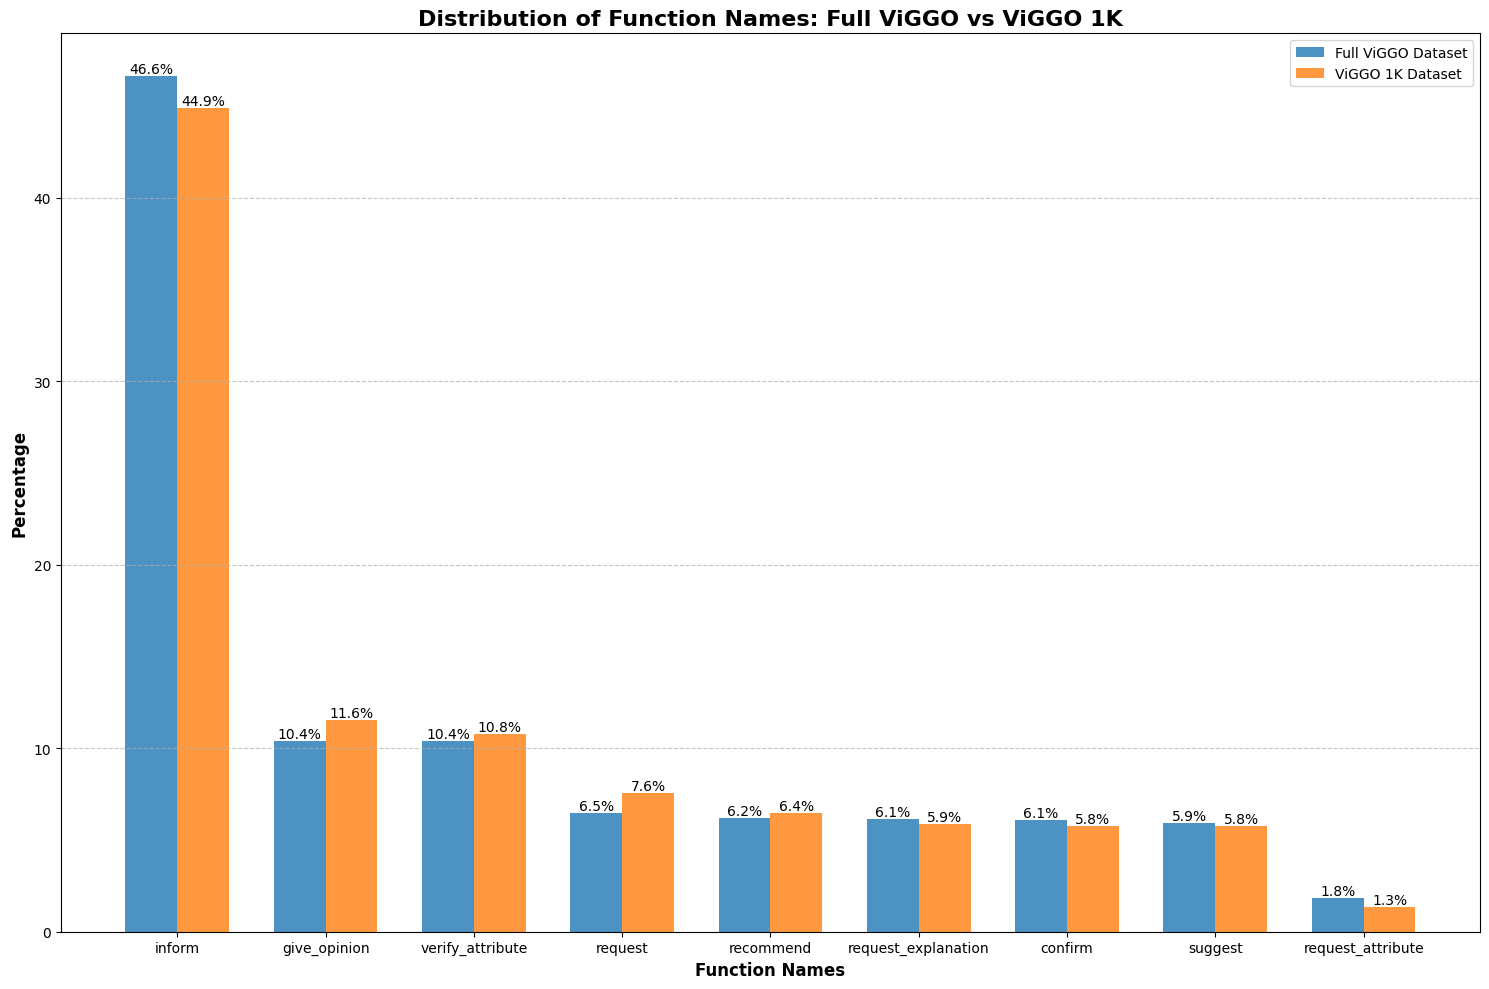

In [95]:
# Plotting the 
plt.figure(figsize=(15, 10))

# Create a grouped bar plot
bar_width = 0.35
index = np.arange(len(function_name_percentages))

plt.bar(index, function_name_percentages.values(), bar_width, label='Full ViGGO Dataset', color='#1f77b4', alpha=0.8)
plt.bar(index + bar_width, function_name_percentages_1K.values(), bar_width, label='ViGGO 1K Dataset', color='#ff7f0e', alpha=0.8)

plt.xlabel('Function Names', fontsize=12, fontweight='bold')
plt.ylabel('Percentage', fontsize=12, fontweight='bold')
plt.title('Distribution of Function Names: Full ViGGO vs ViGGO 1K', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, function_name_percentages.keys(), rotation=0, ha='center')
plt.legend(fontsize=10)

# Add value labels on top of each bar
for i, v in enumerate(function_name_percentages.values()):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate(function_name_percentages_1K.values()):
    plt.text(i + bar_width, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Calculate the Pearson correlation coefficient between the two datasets
- Pearson coefficient helps quantify how similar the distribution of function names is between the full ViGGO dataset and the 1K subset, with a value closer to 1 indicating stronger similarity



Pearson correlation coefficient between full dataset and 1K dataset: 0.9986


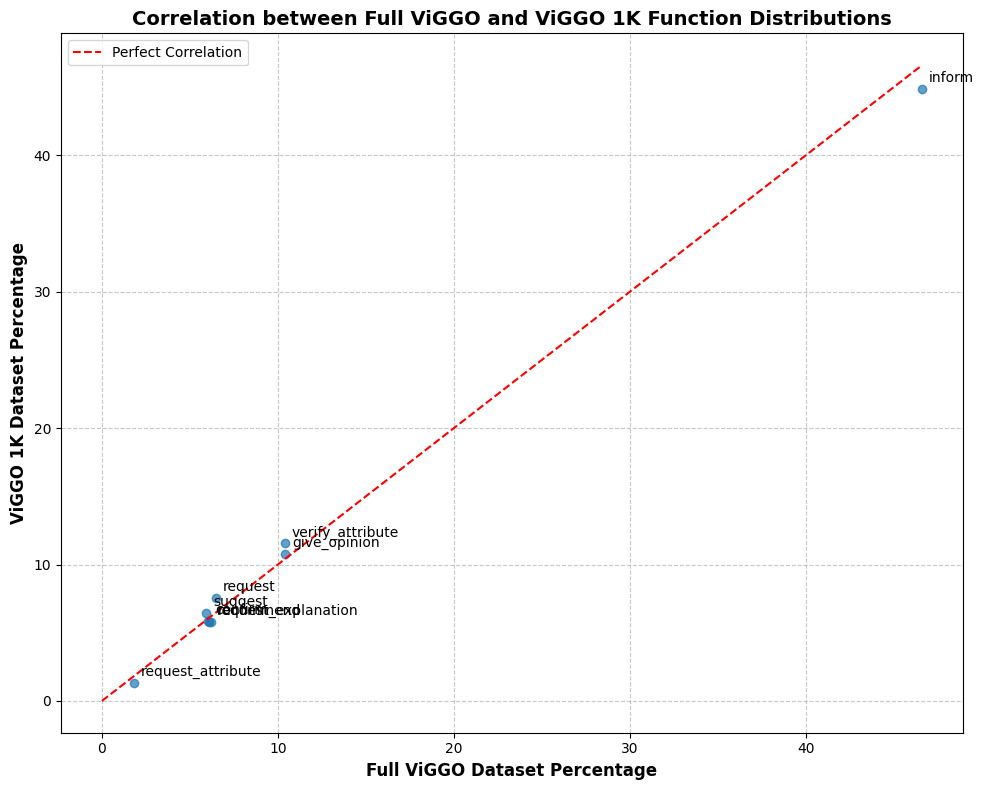

In [97]:
# Calculate Pearson correlation coefficient
common_functions = set(function_name_percentages.keys()) & set(function_name_percentages_1K.keys())
full_data = [function_name_percentages[func] for func in common_functions]
data_1k = [function_name_percentages_1K[func] for func in common_functions]

correlation = np.corrcoef(full_data, data_1k)[0, 1]
print(f"\nPearson correlation coefficient between full dataset and 1K dataset: {correlation:.4f}")

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(10, 8))
plt.scatter(full_data, data_1k, alpha=0.7)
plt.plot([0, max(full_data)], [0, max(full_data)], color='r', linestyle='--', label='Perfect Correlation')
plt.xlabel('Full ViGGO Dataset Percentage', fontsize=12, fontweight='bold')
plt.ylabel('ViGGO 1K Dataset Percentage', fontsize=12, fontweight='bold')
plt.title('Correlation between Full ViGGO and ViGGO 1K Function Distributions', fontsize=14, fontweight='bold')
plt.legend()

for i, func in enumerate(common_functions):
    plt.annotate(func, (full_data[i], data_1k[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Plot the graphs together

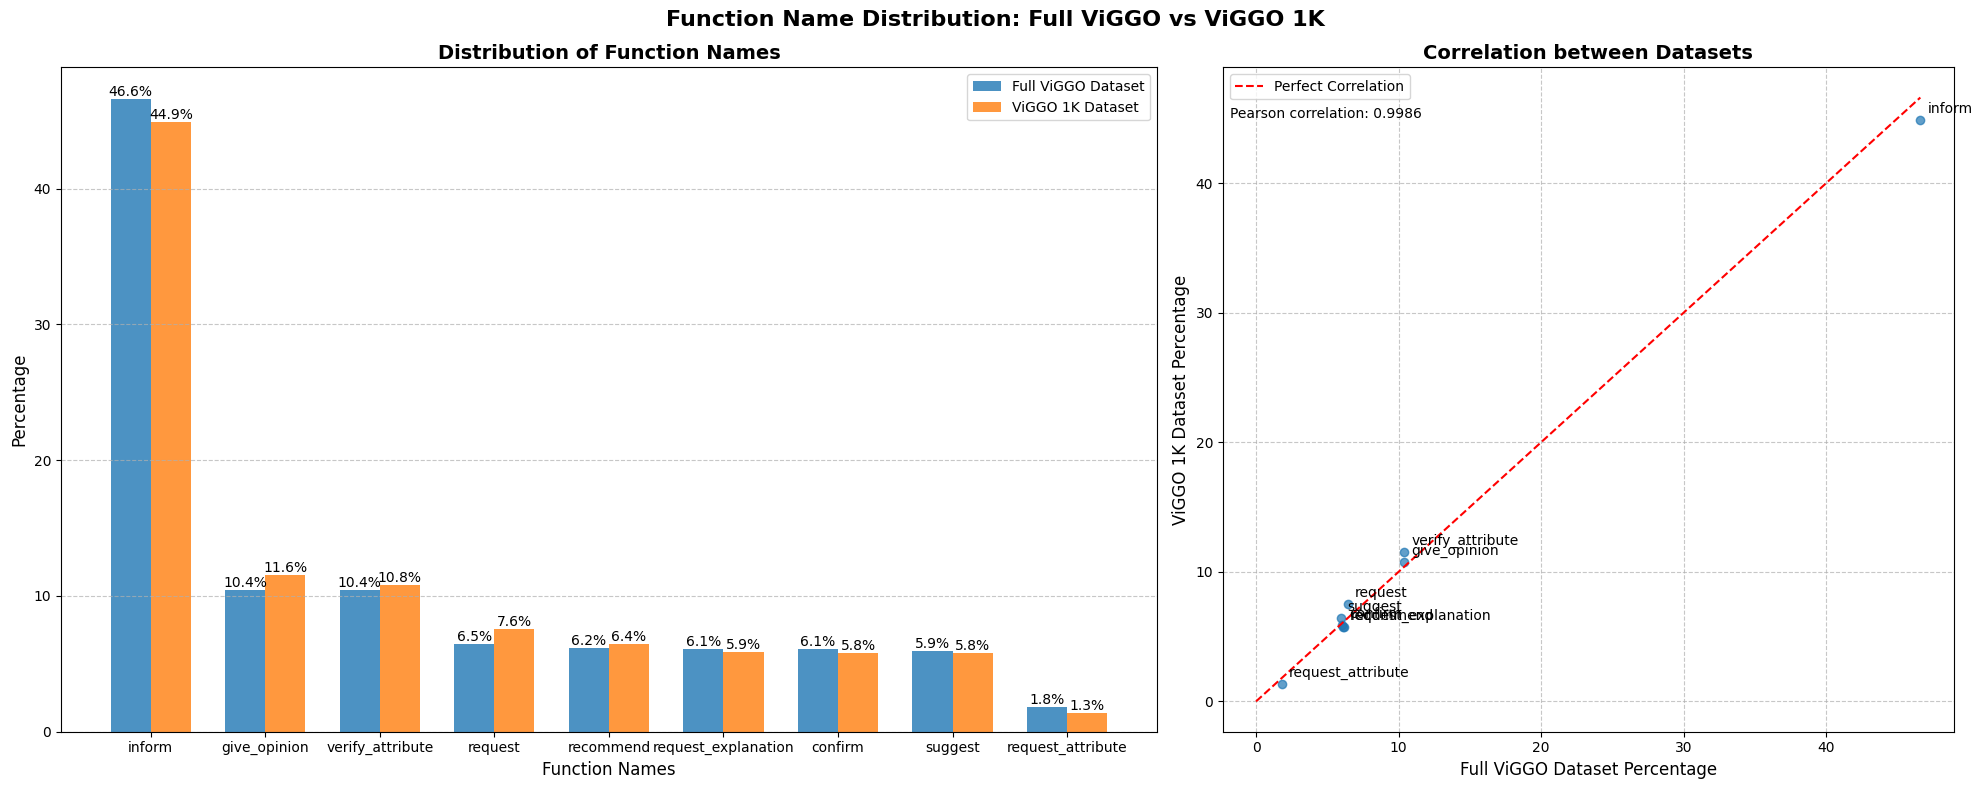

In [125]:
# Create a figure with two subplots side by side, with different widths
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2, width_ratios=[3, 2])  # 3:2 ratio (60% : 40%)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Plot for function percentages (left subplot - 60% width)
bar_width = 0.35
index = np.arange(len(function_name_percentages))

ax1.bar(index, function_name_percentages.values(), bar_width, label='Full ViGGO Dataset', color='#1f77b4', alpha=0.8)
ax1.bar(index + bar_width, function_name_percentages_1K.values(), bar_width, label='ViGGO 1K Dataset', color='#ff7f0e', alpha=0.8)

ax1.set_xlabel('Function Names', fontsize=12)
ax1.set_ylabel('Percentage', fontsize=12)
ax1.set_title('Distribution of Function Names', fontsize=14, fontweight='bold')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(function_name_percentages.keys(), rotation=0, ha='center')
ax1.legend(fontsize=10)

# Add value labels on top of each bar
for i, v in enumerate(function_name_percentages.values()):
    ax1.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate(function_name_percentages_1K.values()):
    ax1.text(i + bar_width, v, f'{v:.1f}%', ha='center', va='bottom')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Pearson correlation (right subplot - 40% width)
common_functions = set(function_name_percentages.keys()) & set(function_name_percentages_1K.keys())
x = [function_name_percentages[func] for func in common_functions]
y = [function_name_percentages_1K[func] for func in common_functions]

ax2.scatter(x, y, alpha=0.7)
ax2.plot([0, max(x)], [0, max(x)], color='r', linestyle='--', label='Perfect Correlation')

for i, func in enumerate(common_functions):
    ax2.annotate(func, (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

ax2.set_xlabel('Full ViGGO Dataset Percentage', fontsize=12)
ax2.set_ylabel('ViGGO 1K Dataset Percentage', fontsize=12)
ax2.set_title('Correlation between Datasets', fontsize=14, fontweight='bold')
ax2.legend()

# Calculate and display Pearson correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]
ax2.text(0.01, 0.94, f'Pearson correlation: {correlation:.4f}', transform=ax2.transAxes, 
         fontsize=10, verticalalignment='top')

ax2.grid(True, linestyle='--', alpha=0.7)

# Add a main title to the figure
fig.suptitle('Function Name Distribution: Full ViGGO vs ViGGO 1K', fontsize=16, fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [126]:
# save the plot
fig.savefig("images/viggo_function_name_distribution_1K.png")